In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [52]:
def data_prep(df, features, output):
    x = df[features].as_matrix()
    b = np.ones(shape=(len(x),1), dtype=np.float32)
    x = np.concatenate((b,x), axis=1)
    y = np.array(df[output])
    return x,y


In [53]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float,
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str,
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 
              'lat':float, 'date':str, 'sqft_basement':int, 
              'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [54]:
sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
train_data = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)
sales.shape

(21613, 21)

In [55]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return predictions

In [56]:
def normalize_features(features):
    norms = np.linalg.norm(features, axis=0)
    normalized_features = features / norms
    return (normalized_features, norms)


In [57]:
class lasso_CD:
    def __init__(self, train_x, train_y, test_x, test_y, l1, tol, norms, init_w = None):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.l1 = l1
        self.tol = tol
        self.norms = norms
        self.w = init_w if init_w is not None else np.zeros(shape=(train_x.shape[1]))
        
    def predict_output(self, feature_matrix):
        predictions = np.dot(feature_matrix, self.w)
        return predictions
    
    def ro_calc(self, i):
        predictions = self.predict_output(feature_matrix = self.train_x)
        y_hat_not_i = predictions - self.w[i]*self.train_x[:,i] 
        ro = np.sum(self.train_x[:,i]*(self.train_y - y_hat_not_i))
        return ro
    
    def lasso_CD_step(self, i, l1_penalty):
        ro = self.ro_calc(i)
        if i == 0: # intercept -- do not regularize
            new_weight_i = ro
        elif ro < -(l1_penalty/2):
            new_weight_i = ro + (l1_penalty/2)
        elif ro > (l1_penalty/2):
            new_weight_i = ro - (l1_penalty/2)
        else:
            new_weight_i = 0.0
        return new_weight_i
    
    def fit(self):
        train_RSS=[]
        T =True
        while T:
            maxchange = 0.0
            for i in range(len(self.w)):
                predictions = self.predict_output(feature_matrix=self.train_x)
                RSS = self.train_rss(predictions=predictions)
                train_RSS.append(RSS)
                new_w_i = self.lasso_CD_step(i, self.l1)
                diff = np.abs(self.w[i] - new_w_i)
                self.w[i] = new_w_i
                if maxchange < diff:
                    maxchange = diff
                    print ("value of i {}, Max Change {}, tolerance: {}".format(i, maxchange, self.tol))
            print ("one iteration complete, maxchange = {}".format(maxchange))
            if maxchange < self.tol:
                print ("Setting T = False")
                T=False
        plt.plot(train_RSS)
        predictions = self.predict_output(feature_matrix=self.train_x)
        RSS = self.train_rss(predictions=predictions)
        return self.w, RSS
    
    def train_rss(self, predictions):
        return np.sum((predictions - self.train_y)**2)
    def w_normalized(self):
        weights_normalized = self.w / self.norms
        return weights_normalized
    def test_RSS(self):
        normalized_w = self.w_normalized()
        test_pred = np.dot(self.test_x, normalized_w)
        test_rss = np.sum((self.test_y - test_pred)**2)
        return test_rss
        

In [58]:
features=['sqft_living', 'bedrooms']
output = 'price'

train_x, train_y = data_prep(df=sales, features=features, output=output)
test_x, test_y = data_prep(df=test_data, features=features, output=output)
normalized_train_x, norms = normalize_features(train_x)

In [59]:
init_w = np.array([1,4,1], dtype=np.float32)


In [60]:
norms

array([  1.47013605e+02,   3.34257264e+05,   5.14075870e+02])

In [61]:
model = lasso_CD(train_x = normalized_train_x, train_y = train_y, test_x = test_x, test_y = test_y, l1 = 1.0 , tol=0, norms=norms, init_w = init_w)

In [62]:
test_ro =[0.0, 0.0, 0.0]
for i in range (len(init_w)):
    test_ro[i]=model.ro_calc(i=i)


In [63]:
normalized_train_x

array([[ 0.00680209,  0.00353021,  0.00583571],
       [ 0.00680209,  0.00768869,  0.00583571],
       [ 0.00680209,  0.00230361,  0.00389048],
       ..., 
       [ 0.00680209,  0.00305154,  0.00389048],
       [ 0.00680209,  0.00478673,  0.00583571],
       [ 0.00680209,  0.00305154,  0.00389048]])

In [64]:
test_ro

[79400300.014522895, 87939470.823251754, 80966698.66623947]

In [65]:
2*np.array(test_ro[1:])

array([  1.75878942e+08,   1.61933397e+08])

In [66]:
normalized_train_x.shape

(21613, 3)

In [67]:
simple_features = ['sqft_living', 'bedrooms']
output = 'price'
initial_weights = np.array([0.0, 0.0, 0.0])
l1_penalty = 1e7
tolerance = 1.0

In [68]:
train_x, train_y = data_prep(df=sales, features=simple_features, output=output)
test_x, test_y = data_prep(df=test_data, features=simple_features, output=output)
normalized_train_x, norms = normalize_features(train_x)

In [69]:
model_1 = lasso_CD(train_x = normalized_train_x, train_y = train_y,
                         test_x = test_x, test_y = test_y,
                         l1 = l1_penalty, tol=tolerance, norms=norms, init_w = initial_weights)

value of i 0, Max Change 79400304.63764462, tolerance: 1.0
one iteration complete, maxchange = 79400304.63764462
value of i 0, Max Change 9138168.376427785, tolerance: 1.0
one iteration complete, maxchange = 9138168.376427785
value of i 0, Max Change 8194809.5183826685, tolerance: 1.0
one iteration complete, maxchange = 8194809.5183826685
value of i 0, Max Change 6598905.081919849, tolerance: 1.0
one iteration complete, maxchange = 6598905.081919849
value of i 0, Max Change 5522173.230819881, tolerance: 1.0
one iteration complete, maxchange = 5522173.230819881
value of i 0, Max Change 4621129.840878405, tolerance: 1.0
one iteration complete, maxchange = 4621129.840878405
value of i 0, Max Change 3867108.1318262443, tolerance: 1.0
one iteration complete, maxchange = 3867108.1318262443
value of i 0, Max Change 3236118.8320114464, tolerance: 1.0
one iteration complete, maxchange = 3236118.8320114464
value of i 0, Max Change 2708086.9574633464, tolerance: 1.0
one iteration complete, maxcha

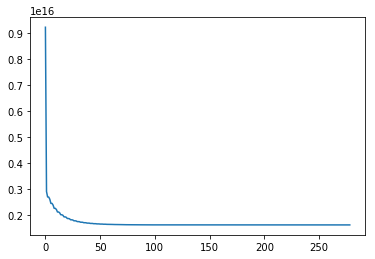

In [70]:
w, rss = model_1.fit()

In [71]:
w

array([ 21624997.9595191 ,  63157247.20788956,         0.        ])

In [72]:
rss

1630492476715386.5

In [73]:
pd.Series(data=w, index=["intercecpt"] + simple_features)

intercecpt     2.162500e+07
sqft_living    6.315725e+07
bedrooms       0.000000e+00
dtype: float64

In [74]:
train_features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated']


In [75]:
train_features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated']

In [82]:
train_x, train_y = data_prep(df=train_data, features=train_features, output=output)
test_x, test_y = data_prep(df=test_data, features=train_features, output=output)
normalized_train_x, norms = normalize_features(train_x)


In [83]:
l1_penalty = 1e7
initialize_weights = np.zeros(14)
tolerance = 1

In [84]:
model_1e7 = lasso_CD(train_x = normalized_train_x, train_y = train_y,
                         test_x = test_x, test_y = test_y,
                         l1 = l1_penalty, tol=tolerance, norms=norms, init_w = initialize_weights)

value of i 0, Max Change 71114625.71488702, tolerance: 1
one iteration complete, maxchange = 71114625.71488702
value of i 0, Max Change 5024356.370547488, tolerance: 1
one iteration complete, maxchange = 5024356.370547488
value of i 0, Max Change 5012324.915982254, tolerance: 1
one iteration complete, maxchange = 5012324.915982254
value of i 0, Max Change 5000676.422620915, tolerance: 1
one iteration complete, maxchange = 5000676.422620915
value of i 0, Max Change 4991243.174673185, tolerance: 1
one iteration complete, maxchange = 4991243.174673185
value of i 0, Max Change 4984361.344819717, tolerance: 1
one iteration complete, maxchange = 4984361.344819717
value of i 0, Max Change 4979504.930990152, tolerance: 1
one iteration complete, maxchange = 4979504.930990152
value of i 0, Max Change 4973806.566812009, tolerance: 1
one iteration complete, maxchange = 4973806.566812009
value of i 0, Max Change 2629220.747802753, tolerance: 1
value of i 3, Max Change 2879223.0189885423, tolerance:

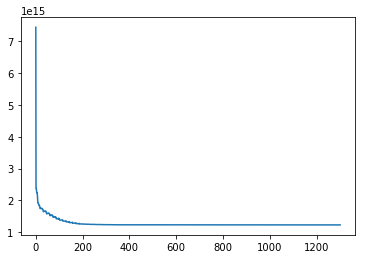

In [85]:
model_1e7_w, mode_1e7_rss = model_1e7.fit()

In [86]:
pd.Series(data=model_1e7_w, index=["intercecpt"] + train_features)

intercecpt       2.442960e+07
bedrooms         0.000000e+00
bathrooms        0.000000e+00
sqft_living      4.838917e+07
sqft_lot         0.000000e+00
floors           0.000000e+00
waterfront       3.317511e+06
view             7.329962e+06
condition        0.000000e+00
grade            0.000000e+00
sqft_above       0.000000e+00
sqft_basement    0.000000e+00
yr_built         0.000000e+00
yr_renovated     0.000000e+00
dtype: float64

In [87]:
model_1e7_test_RSS=model_1e7.test_RSS()

In [88]:
model_1e7_test_RSS

275962075920366.75

In [89]:
l1_penalty = 1e8
initialize_weights = np.zeros(14)
tolerance = 1.0

In [90]:
model_1e8 = lasso_CD(train_x = normalized_train_x, train_y = train_y,
                         test_x = test_x, test_y = test_y,
                         l1 = l1_penalty, tol=tolerance, norms=norms, init_w = initialize_weights)

value of i 0, Max Change 71114625.71488702, tolerance: 1.0
one iteration complete, maxchange = 71114625.71488702
one iteration complete, maxchange = 0.0
Setting T = False


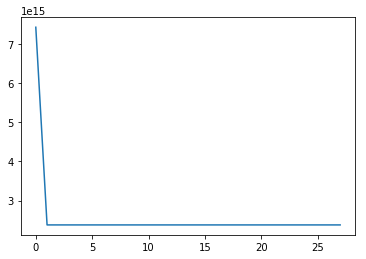

In [91]:
model_1e8_w, mode_1e8_rss = model_1e8.fit()

In [92]:
pd.Series(data=model_1e8_w, index=["intercecpt"] + train_features)

intercecpt       7.111463e+07
bedrooms         0.000000e+00
bathrooms        0.000000e+00
sqft_living      0.000000e+00
sqft_lot         0.000000e+00
floors           0.000000e+00
waterfront       0.000000e+00
view             0.000000e+00
condition        0.000000e+00
grade            0.000000e+00
sqft_above       0.000000e+00
sqft_basement    0.000000e+00
yr_built         0.000000e+00
yr_renovated     0.000000e+00
dtype: float64

In [93]:
model_1e8_test_RSS=model_1e8.test_RSS()

In [94]:
model_1e8_test_RSS

537166151497322.75

In [95]:
l1_penalty = 1e4
tolerance = 5e5
initialize_weights = np.zeros(14)


In [96]:
model_1e4 = lasso_CD(train_x = normalized_train_x, train_y = train_y,
                         test_x = test_x, test_y = test_y,
                         l1 = l1_penalty, tol=tolerance, norms=norms, init_w = initialize_weights)

value of i 0, Max Change 71114625.71488702, tolerance: 500000.0
one iteration complete, maxchange = 71114625.71488702
value of i 0, Max Change 659274.8667703122, tolerance: 500000.0
value of i 1, Max Change 2475949.6731294086, tolerance: 500000.0
value of i 2, Max Change 3528456.786442129, tolerance: 500000.0
value of i 3, Max Change 3584857.428301966, tolerance: 500000.0
value of i 5, Max Change 4863287.9628752805, tolerance: 500000.0
value of i 6, Max Change 4927972.809879439, tolerance: 500000.0
value of i 10, Max Change 5280259.745523491, tolerance: 500000.0
value of i 12, Max Change 8441276.04584171, tolerance: 500000.0
one iteration complete, maxchange = 8441276.04584171
value of i 0, Max Change 51571.55777233839, tolerance: 500000.0
value of i 1, Max Change 1616553.850591478, tolerance: 500000.0
value of i 2, Max Change 3094348.4299384113, tolerance: 500000.0
value of i 5, Max Change 3514876.5809149425, tolerance: 500000.0
value of i 10, Max Change 4166512.5146880373, tolerance:

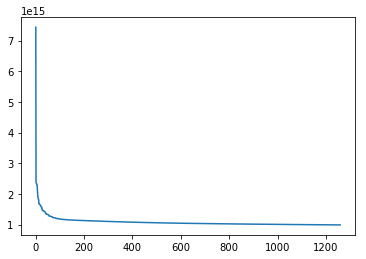

In [97]:
model_1e4_w, mode_1e4_rss = model_1e4.fit()

In [98]:
pd.Series(data=model_1e4_w, index=["intercecpt"] + train_features)

intercecpt       7.856474e+07
bedrooms        -2.209740e+07
bathrooms        1.279107e+07
sqft_living      9.380809e+07
sqft_lot        -2.013173e+06
floors          -4.219185e+06
waterfront       6.482843e+06
view             7.127409e+06
condition        5.001665e+06
grade            1.432752e+07
sqft_above      -1.577096e+07
sqft_basement   -5.159591e+06
yr_built        -8.449534e+07
yr_renovated     2.824439e+06
dtype: float64

In [99]:
model_1e4_test_RSS=model_1e4.test_RSS()

In [100]:
model_1e4_test_RSS

228459958971393.28

In [101]:
weights1e7_normalized = model_1e7_w / norms
weights1e8_normalized = model_1e8_w / norms
weights1e4_normalized = model_1e4_w / norms
weights1e7_normalized

array([  1.85285530e+05,   0.00000000e+00,   0.00000000e+00,
         1.61317458e+02,   0.00000000e+00,   0.00000000e+00,
         2.87664705e+05,   6.91937041e+04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [106]:
print (sum((test_y - predict_output(test_x,weights1e7_normalized) )**2))

2.7596207592e+14


In [107]:
print (sum((test_y - predict_output(test_x,weights1e8_normalized) )**2))

5.37166151497e+14


In [108]:
print (sum((test_y - predict_output(test_x,weights1e4_normalized) )**2))

2.28459958971e+14
